# FIFA 2020 Experiment

### Import packages & load/process data

In [1]:
# Import necessary packages
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from balancers import BinaryBalancer
from utils import BertClassifier, Dataset, train
import os
import seaborn as sns
sns.set_theme()

# sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

# pytorch
import torch

In [2]:
# Import fifa 20 dataset
all_data = pd.read_csv('data/players_20.csv')
results_dir = 'results/'

# Set the nationalities you want to use
c1 = 'England'
c2 = 'Argentina'
nationalities = [c1,c2]

# Keep relevant columns
o_data = all_data[['long_name','age','nationality','overall','wage_eur']].copy(deep = True)

# Change column names of nationality and wage_eur to a and y 
o_data.rename(columns = {'nationality':'a', 'wage_eur':'y'}, inplace = True)

# Restrict to specified nationalities
o_data = o_data.loc[(o_data['a'].isin([nationalities[0], nationalities[1]]))]
print('Number of players:', o_data.shape[0])

# Only keep relevant feagires and outcomes
data = o_data[['long_name','age','a','overall','y']].copy(deep = True)

# Binarize nationality
data = data.replace(nationalities[0],0)
data = data.replace(nationalities[1],1)

# Reset the index
data = data.reset_index(drop=True)

# Binarize outcome using median outcome
data.loc[data['y'] < np.median(data['y']), 'y'] = 0
data.loc[data['y'] >= np.median(data['y']), 'y'] = 1

Number of players: 2553


In [3]:
# Create new column to stratify data and calculate base rates
group = []
for i in range(data.shape[0]):
    # w
    if np.sum(data[['a','y']].iloc[i] == [0,0]) == 2:
        group.append(1)
    # v
    if np.sum(data[['a','y']].iloc[i] == [1,0]) == 2:
        group.append(2)
    # s
    if np.sum(data[['a','y']].iloc[i] == [0,1]) == 2:
        group.append(3)
    # r
    if np.sum(data[['a','y']].iloc[i] == [1,1]) == 2:
        group.append(4)

# Add column to the data
data['group'] = group

# Calculate base rates
total = data.shape[0]
r = np.sum(data['group'] == 4)/total
s = np.sum(data['group'] == 3)/total
v = np.sum(data['group'] == 2)/total
w = np.sum(data['group'] == 1)/total

### Learn a predictor for A (nationality) using player name

In [4]:
# Learn a predictor for nationality using name with BERT
model = BertClassifier()
LR = 1e-5

# Splitting data into necessary datasets
d_train, d_test = train_test_split(data, train_size = 0.75, stratify=data['group'])

# Train model
EPOCHS = 5
train(model, d_train, d_test, LR, EPOCHS)

100%|██████████| 957/957 [00:40<00:00, 23.48it/s]


Epochs: 1 | Train Loss:  0.187             | Train Accuracy:  0.933             | Val Loss:  0.132             | Val Accuracy:  0.961


100%|██████████| 957/957 [00:41<00:00, 23.25it/s]


Epochs: 2 | Train Loss:  0.066             | Train Accuracy:  0.980             | Val Loss:  0.176             | Val Accuracy:  0.955


100%|██████████| 957/957 [00:40<00:00, 23.41it/s]


Epochs: 3 | Train Loss:  0.035             | Train Accuracy:  0.987             | Val Loss:  0.161             | Val Accuracy:  0.961


100%|██████████| 957/957 [00:40<00:00, 23.37it/s]


Epochs: 4 | Train Loss:  0.013             | Train Accuracy:  0.996             | Val Loss:  0.144             | Val Accuracy:  0.956


100%|██████████| 957/957 [00:40<00:00, 23.45it/s]


Epochs: 5 | Train Loss:  0.007             | Train Accuracy:  0.998             | Val Loss:  0.188             | Val Accuracy:  0.964


In [5]:
# Use BERT on test set to generate a_hat
xy_test = Dataset(d_test)
xy_test_dataloader = torch.utils.data.DataLoader(xy_test, batch_size=len(xy_test))
device = torch.device("cuda:1")
model.to(device)
model = model.eval()
with torch.no_grad():
    for xy_test_input, xy_test_label, xy_test_remain in xy_test_dataloader:
        xy_test_label = xy_test_label.to(device).float()
        mask = xy_test_input['attention_mask'].to(device)
        input_id = xy_test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask).reshape(1,-1)[0]
        a_hat = (output >= 0.5)*1.0
        a_hat = a_hat.cpu().numpy()

### Learn a predictor for Y (wage > median(wage)) using players age and overall attribute

In [6]:
# Learn classifier for y
x_test = d_test[['overall', 'age']]
y_test = d_test['y'].to_numpy()

# Create Classifier
clf = RandomForestClassifier(n_estimators=10)

# Split data into features and labels
x_train = d_train[['overall', 'age']]
y_train = d_train['y']

# Fit classifier
clf.fit(x_train.to_numpy(), y_train)

# Evaluate probabilities/y_hat on test set
y_prob = clf.predict_proba(x_test.to_numpy())
    
# Calculate y_hat
y_hat = (y_prob[:,1] >= 0.5).astype('float')

### Perform necessary calculations for results/figures

In [7]:
# Run experiment
iter = 1000
y = y_test
a = d_test['a'].values
num_rows = len(a)

d_tpr = []
d_fpr = []
d_tpr_fair = []
d_fpr_fair = []
d_tpr_opt = []
d_fpr_opt = []

b_tpr = []
b_fpr = []
th_b_tpr_fair = []
th_b_fpr_fair = []
ac_b_tpr_fair = []
ac_b_fpr_fair = []
th_b_tpr_opt = []
th_b_fpr_opt = []
ac_b_tpr_opt = []
ac_b_fpr_opt = []

o_loss = []
fair_loss = []
opt_loss = []
k = 0 

while k < iter:
    random_indices = np.random.choice(num_rows, size=num_rows, replace=True)
    a_s = a[random_indices]
    y_s = y[random_indices]
    a_hat_s = a_hat[random_indices]
    y_hat_s = y_hat[random_indices]
    true_balancer = BinaryBalancer(y=y_s, y_=y_hat_s, a=a_s, a_hat = a_hat_s, adjusted = False)

    # See if conditions are met
    if true_balancer.assumption == 0:
        true_balancer.adjust(con = 'tpr/fpr', obj = 'project')
        true_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)
    
    # P(Y = 0) and P(Y=1)
    p0 = true_balancer.overall_rates.num_neg
    p1 = true_balancer.overall_rates.num_pos
    
    # Measure true bias
    d_tpr.append(np.abs(true_balancer.a_gr_list[1].tpr - true_balancer.a_gr_list[0].tpr))
    d_fpr.append(np.abs(true_balancer.a_gr_list[1].fpr - true_balancer.a_gr_list[0].fpr))

    # Calculate worst case fairness violations
    b_tpr.append(np.max([np.abs(true_balancer.bounds['tpr']['ub']), np.abs(true_balancer.bounds['tpr']['lb'])]))
    b_fpr.append(np.max([np.abs(true_balancer.bounds['fpr']['ub']), np.abs(true_balancer.bounds['fpr']['lb'])]))
    o_loss.append(p0*p1*(1 - true_balancer.overall_rates.tpr  + true_balancer.overall_rates.fpr))

    # Adjust by enforcing fairness with respect to A_hat
    true_balancer.adjust(con = 'tpr/fpr', obj = 'fair')
    fair_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)

    # Calculate new true fairness violations
    d_tpr_fair.append(np.abs(fair_balancer.a_gr_list[1].tpr - fair_balancer.a_gr_list[0].tpr))
    d_fpr_fair.append(np.abs(fair_balancer.a_gr_list[1].fpr - fair_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    th_b_tpr_fair.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_fair.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    ac_b_tpr_fair.append(np.max([np.abs(fair_balancer.bounds['tpr']['ub']), np.abs(fair_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_fair.append(np.max([np.abs(fair_balancer.bounds['fpr']['ub']), np.abs(fair_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    fair_loss.append(p0*p1*(1 - fair_balancer.overall_rates.tpr + fair_balancer.overall_rates.fpr))

    # Adjust optimally
    true_balancer.adjust(con = 'tpr/fpr', obj = 'opt')
    opt_balancer = BinaryBalancer(y=y_s, y_=true_balancer.y_adj, a=a_s, a_hat = a_hat_s)

    # Calculate new true fairness violations
    d_tpr_opt.append(np.abs(opt_balancer.a_gr_list[1].tpr - opt_balancer.a_gr_list[0].tpr))
    d_fpr_opt.append(np.abs(opt_balancer.a_gr_list[1].fpr - opt_balancer.a_gr_list[0].fpr))

    # Calculate new worst case fairness violations
    th_b_tpr_opt.append(np.max([np.abs(true_balancer.new_bounds['tpr']['ub']), np.abs(true_balancer.new_bounds['tpr']['lb'])]))
    th_b_fpr_opt.append(np.max([np.abs(true_balancer.new_bounds['fpr']['ub']), np.abs(true_balancer.new_bounds['fpr']['lb'])]))
    ac_b_tpr_opt.append(np.max([np.abs(opt_balancer.bounds['tpr']['ub']), np.abs(opt_balancer.bounds['tpr']['lb'])]))
    ac_b_fpr_opt.append(np.max([np.abs(opt_balancer.bounds['fpr']['ub']), np.abs(opt_balancer.bounds['fpr']['lb'])]))

    # Calculate new loss
    opt_loss.append(p0*p1*(1 - opt_balancer.overall_rates.tpr  + opt_balancer.overall_rates.fpr))

    if k%200 == 0:
        print(k)
    k = k+1 

0
200
400
600
800


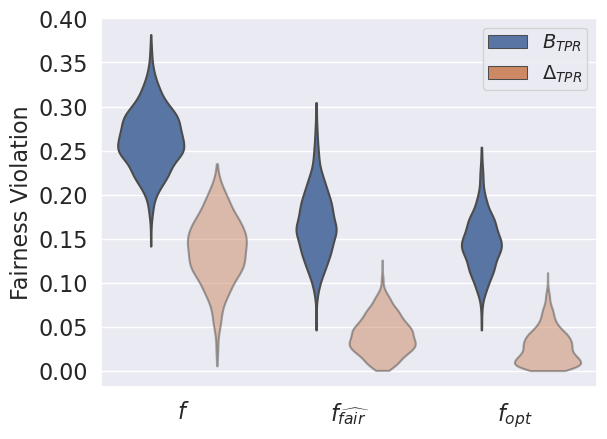

In [8]:
# Plotting theoretical tpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + th_b_tpr_fair + th_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
                hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir + c1 + '_' + c2, 'theo_b_tpr.pdf'), bbox_inches="tight")

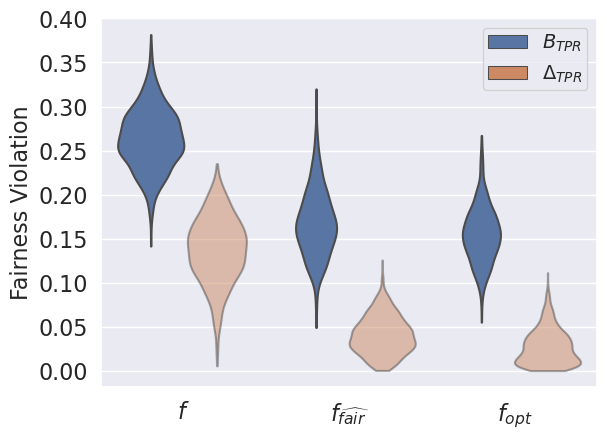

In [9]:
# Plotting actual tpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_tpr + d_tpr_fair + d_tpr_opt + b_tpr + ac_b_tpr_fair + ac_b_tpr_opt
metric_label = [r'$\Delta_{TPR}$']*3*iter + [r'$B_{TPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
                hue_order= [r'$B_{TPR}$', r'$\Delta_{TPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir + c1 + '_' + c2, 'ac_b_tpr.pdf'),bbox_inches="tight")

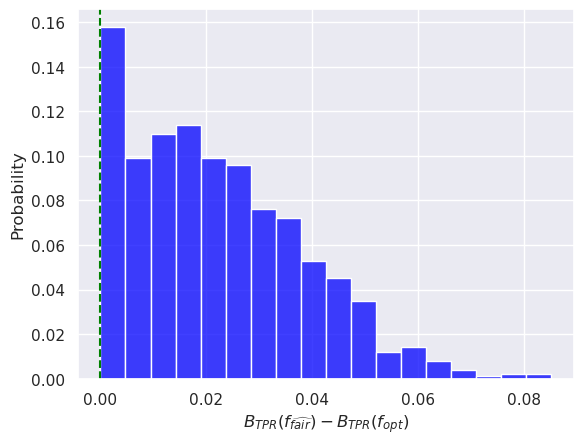

In [10]:
# Difference between theoretical tpr bounds
diff_2 = np.array(th_b_tpr_fair) - np.array(th_b_tpr_opt)
sns.histplot(diff_2, stat = 'probability', color = 'blue')
plt.xlabel(r'$B_{TPR}(f_{\widehat{fair}}) - B_{TPR}(f_{opt})$')
plt.axvline(0, linestyle = '--', color = 'green')
plt.savefig(os.path.join(results_dir + c1 + '_' + c2, 'b_tpr_diff.pdf'),bbox_inches="tight")

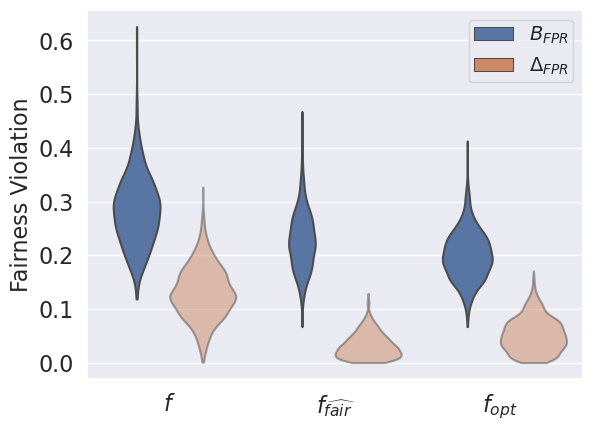

In [11]:
# Plotting theoretical fpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_fpr + d_fpr_fair + d_fpr_opt + b_fpr + th_b_fpr_fair + th_b_fpr_opt
metric_label = [r'$\Delta_{FPR}$']*3*iter + [r'$B_{FPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
               hue_order= [r'$B_{FPR}$', r'$\Delta_{FPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir + c1 + '_' + c2, 'theo_b_fpr.pdf'),bbox_inches="tight")

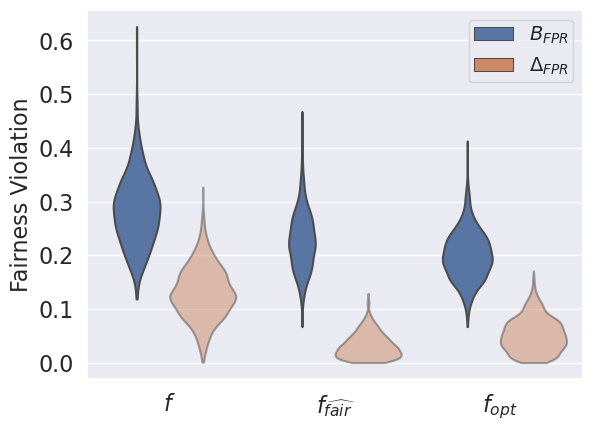

In [12]:
# Plotting actual fpr bounds and actual values
method = [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter + [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
metrics = d_fpr + d_fpr_fair + d_fpr_opt + b_fpr + th_b_fpr_fair + th_b_fpr_opt
metric_label = [r'$\Delta_{FPR}$']*3*iter + [r'$B_{FPR}$']*3*iter
b_tpr_df = pd.DataFrame(list(zip(metrics, method, metric_label)), columns =['Metric', 'Classifier', 'Metric Label'])
ax = sns.violinplot(data=b_tpr_df, x = 'Classifier', y = 'Metric', cut = 0, hue = 'Metric Label', \
               hue_order= [r'$B_{FPR}$', r'$\Delta_{FPR}$'], inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Fairness Violation', fontsize=16)
plt.legend(fontsize=14, borderpad=0.25)
ax.collections[1].set_alpha(0.5)
ax.collections[3].set_alpha(0.5)
ax.collections[5].set_alpha(0.5)
plt.savefig(os.path.join(results_dir + c1 + '_' + c2, 'ac_b_fpr.pdf'),bbox_inches="tight")

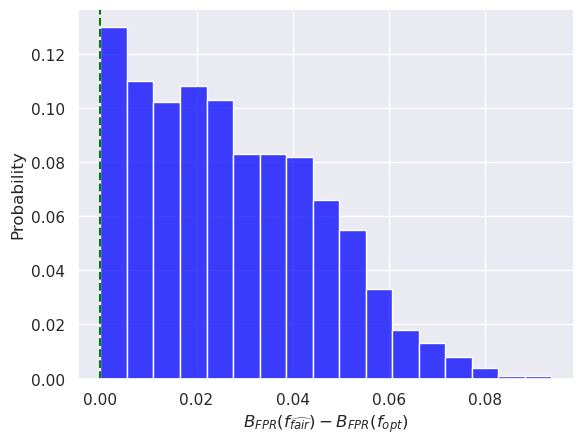

In [13]:
# Difference between theoretical fpr bounds
diff_2 = np.array(th_b_fpr_fair) - np.array(th_b_fpr_opt)
sns.histplot(diff_2, stat = 'probability', color = 'blue')
plt.xlabel(r'$B_{FPR}(f_{\widehat{fair}}) - B_{FPR}(f_{opt})$')
plt.axvline(0, linestyle = '--', color = 'green')
plt.savefig(os.path.join(results_dir + c1 + '_' + c2, 'b_fpr_diff.pdf'),bbox_inches="tight")

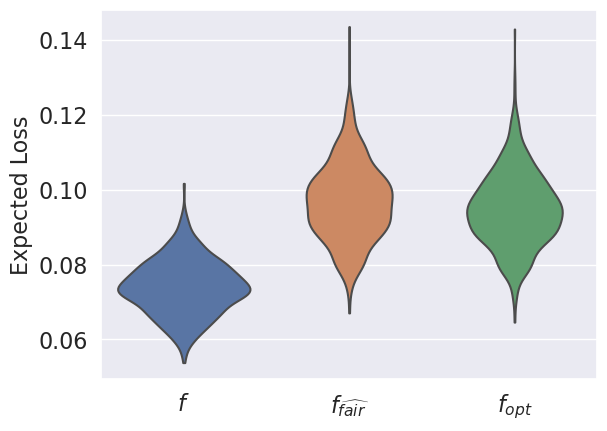

In [14]:
# Plotting expected loss
method =  [r'$f$']*iter + [r'$f_{\widehat{fair}}$']*iter + [r'$f_{opt}$']*iter
losses = o_loss + fair_loss + opt_loss
loss_df = pd.DataFrame(list(zip(losses, method)), columns =['Expected Loss', 'Classifier'])
sns.violinplot(data=loss_df, x = 'Classifier', y = 'Expected Loss', cut = 0, inner = None)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('')
plt.ylabel('Expected Loss', fontsize=16)
plt.savefig(os.path.join(results_dir + c1 + '_' + c2, 'loss.pdf'),bbox_inches="tight")